In [117]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkit as nk
from pygsp import graphs as gsp_graphs
import seaborn as sns
import itertools 
import random
from scipy.stats import gaussian_kde
import torch
from torch_geometric.data import Data
import pandas as pd
from sklearn.preprocessing import StandardScaler

from graspy.models import DCSBMEstimator
from graspy.simulations import er_np, sbm
# no module from hyppo._utils import gaussian in latent_distribution_test.py only available in version 0.1.3
# https://github.com/neurodata/hyppo/tree/v0.1.3

# Stochastic Block Model 

**Vertex Partitioning**: The set of vertices in the graph is partitioned into 
$k$ distinct groups or blocks. Each vertex belongs to exactly one block.

**Block Probability Matrix**: The connectivity between nodes is determined by a 
$k×k$ symmetric probability matrix $P$, where each entry $P_{ij}$
represents the probability of an edge between a node in block iand a node in block $j$.

**Edge Independence**: The presence or absence of edges between any two nodes is independent of other edges in the graph, conditional on the block memberships of the nodes. )

**Homogeneity within Blocks**: Nodes within the same block are statistically indistinguishable in terms of their connection probabilities to other nodes (both within and across blocks).

**Flexibility in Block Interactions**: The model can represent various types of block interactions, such as *assortative mixing* (high probability of connections within blocks), *disassortative mixing* (high probability of connections between blocks), or any pattern in between.

**Parameterization**: The model is typically parameterized by the block assignment vector and the block probability matrix. These parameters can be estimated from data using methods like maximum likelihood estimation or Bayesian inference.

**Multigraphs**: Two or more edges that connect the same pair of vertices. These are sometimes used to represent multiple relationships or interactions between the same entities.
The adjacency matrix for a multigraph is conventionally defined such that $A_{ij}$ is equal to the number of edges
between vertices i and j when i =/= j,

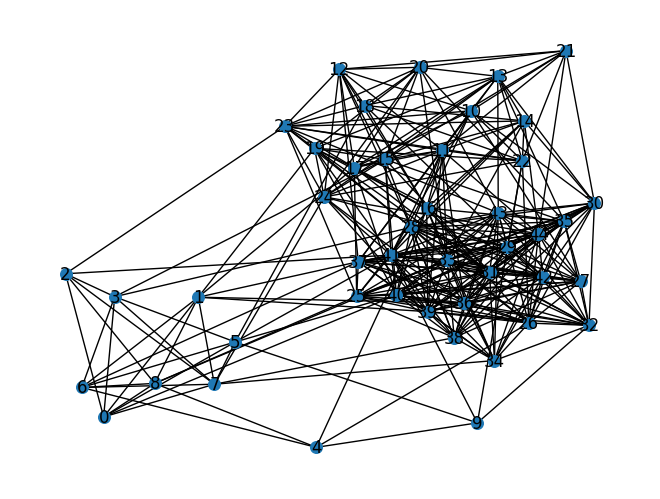

In [7]:
block_sizes = [10, 15, 20]  # Sizes of three blocks
p_matrix = [
    [ .7,  .1, .05],  # Probabilities of links within block 1, between 1-2, and 1-3
    [ .1,  .6, .15],  # Probabilities of links between 2-1, within block 2, and 2-3
    [.05, .15,  .8 ]  # Probabilities of links between 3-1, 3-2, and within block 3
]

G = nx.stochastic_block_model(block_sizes, p_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=70, with_labels=False)
plt.show()

**SBM Algorithm**

In [ ]:
def sbm(sizes, p):
    """
    :param sizes:  [7, 5, 10]
    :param p: [[0.25, 0.05, 0.02],
               [0.05, 0.35, 0.07],
               [0.02, 0.07, 0.40]]
    :return:
    """
    nodelist = range(sum(sizes))

    g = nx.Graph()
    size_cumsum = [sum(sizes[:x]) for x in range(len(sizes) + 1)] # [0,7,12,22]
    partition = [set(nodelist[size_cumsum[x]:size_cumsum[x + 1]]) for x in range(len(size_cumsum) - 1)]
    # block 1 = {0,1,2,...,6},block 2 = {7,8,...,11}, block 3 = {12,13,...,21}

    for block_id, nodes in enumerate(partition):
        for node in nodes:
            g.add_node(node, block=block_id)
    # So far, only empty graph has been generated with block id's(all nodes)

    for i, j in itertools.combinations_with_replacement(range(len(sizes)), 2): 
        # loop over p-matrix: (all row-col combinations of the upper triangular part)
        edges = itertools.combinations(partition[i], 2) if i == j \
            else itertools.product(partition[i], partition[j]) # generate all edgecobination between block i and j (for i==j and i=/=j)
        for e in edges:
            if random.random() < p[i][j]: # random unif(0,1) flag 
                g.add_edge(*e)

    return g

# Degree-Corrected Stochastic Block Model (DCSBM)

While SBM is useful for modeling community structure with uniform connectivity within blocks, it is not
well-suited for networks where nodes in the same community might have vastly different degrees. This can lead to
inaccuracies in modeling real-world networks where degree variation is common.
Nodes are assigned to blocks as before, but each node $i$ also gets an additional parameter $θ_i$,
which scales the number of edges connecting it to other nodes

#### Degree-Corrected Stochastic Block Model (DCSBM)

1. **Heterogeneity within Blocks**:
   - DCSBM introduces a degree parameter for each node, allowing nodes within the same block to have different expected degrees. This model accommodates the degree variations observed in many real networks.

2. **Connection Probability**:
   - In DCSBM, the probability of an edge between two nodes $i$ and $j$ is not only influenced by their block memberships but also by their individual degree parameters $θ_i$ and $θ_j$. The edge probability is modeled as $θ_i θ_j P_{ij}$, where $P_{ij}$ is still a block-level probability but scaled by the degree parameters of the nodes involved.

3. **Applications**:
   - DCSBM is particularly useful for networks where nodes in the same community or block have different levels of connectivity. It is more flexible in capturing the structure of networks with power-law degree distributions, which are common in social and biological networks.


In [30]:
#from graspy.models import DCSBMEstimator, EREstimator, SBMEstimator
#from graspy.models.sbm import _block_to_full, _get_block_indices
from graspy.simulations import er_np, sbm
# https://docs.neurodata.io/notebooks/pedigo/graspologic/2020/09/24/latent_model_tutorial.html

In [4]:
community_sizes = [70, 50, 100]
n = sum(community_sizes)
B = [[.5, .15, .12],
     [.15, .5, .09],
     [.12, .09,  .5]]

labels = np.concatenate([np.full(n, i) for i, n in enumerate(community_sizes)])

#degree_corrections = np.random.beta(2, 2, size=sum(community_sizes)) # theta with a distribution between 0 and 1 
degree_corrections = np.random.uniform(2, 50, sum(community_sizes)) ** (-1/.5)

for label in np.unique(labels): # one label per block, here 2 
    mask = (labels == label)
    degree_corrections[mask] = np.sort(degree_corrections[mask])[::-1] # sort in increasing order 
    comm_sum = np.sum(degree_corrections[mask])
    degree_corrections[mask] = degree_corrections[mask] / comm_sum # Block-wise-normalize 

dcsbm_graph = sbm(community_sizes, B, dc=degree_corrections, loops=False)
#dcsbm_model = DCSBMEstimator(directed=False, loops=False)
#dcsbm_model.fit(dcsbm_graph, y=labels)

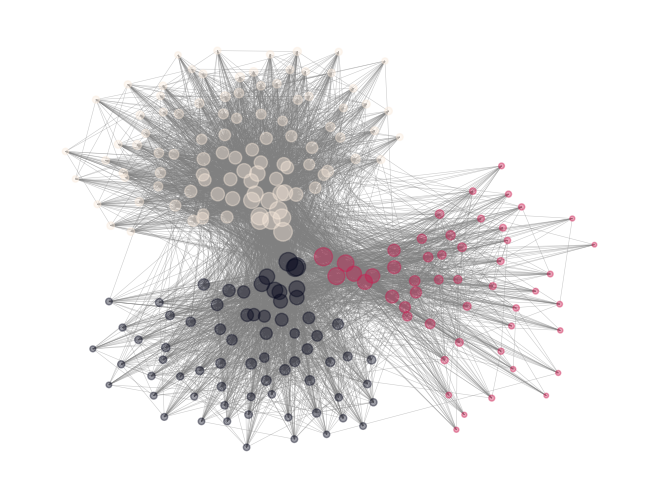

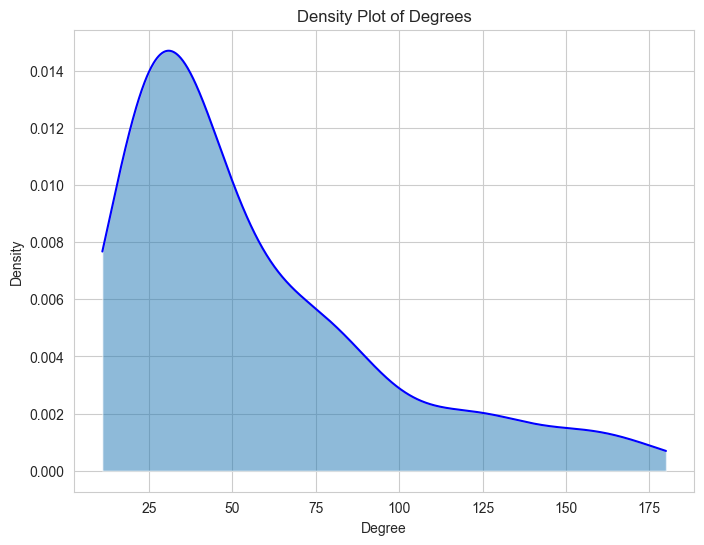

In [62]:
G = nx.from_numpy_array(dcsbm_graph)
degrees = [G.degree(n) for n in G.nodes()]
pos = nx.spring_layout(G)

nx.draw(G, pos, node_size=degrees, node_color=labels,edge_color='grey', font_color='black', width=.4, alpha=.4)
plt.show()


# Calculate the point density
density = gaussian_kde(degrees)
x = np.linspace(min(degrees), max(degrees), 1000)
density_values = density(x)

# Plot the density plot
plt.figure(figsize=(8, 6))
plt.plot(x, density_values, color='blue')
plt.fill_between(x, density_values, alpha=0.5)
plt.title('Density Plot of Degrees')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# ADC-SBM Algorithm 

In [118]:
class Adc_sbm:
    
    def __init__(self, community_sizes:list, B:np.array):
        """
        :param community_sizes: [70, 50, 100]
        :param B: 
        """
        self.nx = None
        self.edge_index = None
        self.pos_edge_label_index = None
        self.neg_edge_label_index = None 
        self.degrees = None
        
        self.community_sizes = community_sizes
        self.n_nodes = sum(community_sizes)
        self.labels = np.concatenate([np.full(n, i) for i, n in enumerate(community_sizes)])
        
        self.B = B
        
        self.dc = None
        self.x = None
        self.cluster_labels = None
    
    
    def set_x(self, n_c: int, mu: list, sigma: list, w: list, stochastic=True):
        """
        if stochastic = True -> w must be list of integers 
        :param stochastic: fixed or stochastic cluster components
        :param n_c: number of cluster components
        :param mu: list of tuples corresponding to
        num of features (tuple-length) and number of components (list-length)
        :param sigma: list of Covariance matrices
        :param w: mixture weights
        :return: None

        Add numeric features. Only used within the class. The X values for each component are sorted (asc. order)
        So indexing is straightforward (beneficial for Adj. Matrix?)
        """
        assert len(mu) == len(sigma) == len(w), "Different dimensions chosen for mu, sigma, w. "

        if stochastic:
            # Sample from Gaussian-Mixture Model: 
            component_labels = np.sort(
                np.random.choice(n_c, size=self.n_nodes, p=w)
            )
        else:
            num = np.arange(len(w), dtype=np.int64)
            #times = np.round(self.n_nodes * np.array(w))
            #times = np.array(times, dtype=np.int64) # 'safe' conversion
            component_labels = np.repeat(num,w)
        
        data = np.array([np.random.multivariate_normal(mu[label],
                                                       sigma[label])
                            for label in component_labels])
        
        self.x = data
        self.cluster_labels = component_labels
    
    def correct_degree(self, alpha:float, beta:float, lmbd :float=.5,  distribution:str="exp"):
        """
        :param alpha: lower (or shape parameter) 
        :param beta: upper (or shape parameter)
        :param lmbd: exponential coefficient for shape of 
        :param distribution: 
        :return: 
        """
        # theta with a distribution between 0 and 1 
        assert distribution in ["exp", "beta"], "Distribution must be in [exp, beta]"
        
        if distribution == "exp":
            degree_corrections = np.random.uniform(alpha, beta, self.n_nodes) ** (-1/lmbd)
        
        if distribution == "beta":
            degree_corrections = np.random.beta(alpha, beta, size=self.n_nodes) 

        # Block-Wise degree correction: 
        for label in np.unique(self.labels): # one label per block
            mask = (self.cluster_labels == label)
            degree_corrections[mask] = np.sort(degree_corrections[mask])[::-1] # sort in increasing order 
            comm_sum = np.sum(degree_corrections[mask])
            degree_corrections[mask] = degree_corrections[mask] / comm_sum # Block-wise-normalize 
            
        self.dc = degree_corrections
        
    
    def gen_graph(self):
        """
        Generate either DC-SBM or SBM based on availability of degree correction.  
        """
        if self.dc is not None:
            dcsbm_graph = sbm(community_sizes, B, dc=self.dc, loops=False)
            self.nx = nx.from_numpy_array(dcsbm_graph)
        else:
            sbm_graph = sbm(community_sizes, B, loops=False)
            self.nx = nx.from_numpy_array(sbm_graph)
            
        edge_list = list(self.nx.edges())
        self.edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        self.degrees = np.array([self.nx.degree(n) for n in self.nx.nodes()])
        
    def set_y(self, task:str, beta_degree:float, beta_community:float, beta_x:float,beta0:float=None):
        """
        :param task: 
        :param beta0: 
        :param beta_degree: 
        :param beta_community: 
        :param beta_x: 
        :return: 
        """
        
        #feat_mat = np.concatenate((#np.ones(self.n_nodes),
         #                          pd.get_dummies(g.cluster_labels).to_numpy(dtype=np.float16),
          #                         g.degrees.reshape(-1, 1), 
           #                        g.x), axis=1)
        #beta_vec = np.concatenate((beta_degree, beta_community, beta_x))
        
        scaler = StandardScaler()
        x_continuous = scaler.fit_transform(
            np.concatenate((self.degrees.reshape(-1, 1),
                            self.x),axis=1)
        )

        feat_mat  = np.hstack((x_continuous,
                                  pd.get_dummies(self.cluster_labels).to_numpy(dtype=np.float16)))
        
        weights = np.array([0.5, 1.0, 2.0, 2.0])
        
        beta = np.random.normal(size=feat_mat.shape[1]) * weights

        
    

    def sample_train_edge_labels(self, size: int = None):
        """
        :param size: sample size of pos and neg edges
        Throws an error when not enough negative connections are established.
        """
        assert self.edge_index is not None, "No edge_indices set."

        if not size:
            size = self.n_nodes // 2

        # Positive:
        sidx_pos = np.random.choice(range(self.edge_index.shape[1]), size=size)
        self.pos_edge_label_index = self.edge_index[:, sidx_pos]

        # Negative:
        tuple_pos = set([(int(self.edge_index[0][i]),
                          int(self.edge_index[1][i]))
                         for i in range(self.edge_index.shape[1])])  # Make set of all connected node tuples
        all_permutations = set(list(itertools.combinations(list(range(self.n_nodes)), 2)))

        samp_space = np.array(list(all_permutations - tuple_pos)).T
        # print(samp_space.shape[1] + len(tuple_pos) == len(all_permutations)) # -> True
        assert samp_space.shape[1] >= size, \
            (f"Not enough negative connections to sample from. possible: {samp_space.shape[1]} | "
             f"required:{size}")

        sidx_neg = np.random.choice(range(samp_space.shape[1]), size=size)
        self.neg_edge_label_index = torch.tensor(
            samp_space[:, sidx_neg]
        )

    def set_Data_object(self):
        data = Data(x=torch.tensor(self.x, dtype=torch.float32), 
                    edge_index=self.edge_index, # allready a tensor 
                    #y = torch.tensor(self.y, dtype=torch.float32),
                    pos_edge_label_index=self.pos_edge_label_index, # allready a tensor 
                    neg_edge_label_index=self.neg_edge_label_index) # allready a tensor 
        
        self.DataObject = data

    def plot_data(self, alpha = .9):
        assert self.x is not None and self.cluster_labels is not None, "No data yet created"
        assert 2 <= self.x.shape[1] <= 3, "No plot possible"
        
        if self.x.shape[1] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            sc = ax.scatter(self.x[:, 0], self.x[:, 1], self.x[:, 2], c=self.cluster_labels, alpha=.5)
            cb = plt.colorbar(sc, ax=ax)
            cb.set_label('Cluster Labels')
            plt.show()
            
        if self.x.shape[1] == 2:
            plt.scatter(self.x[:, 0], self.x[:, 1], c=self.cluster_labels, alpha=.5)
            plt.show()
            
    def plot_graph(self,alpha = .9, width=.1):
        
        if self.x.shape[1] == 2:
            pos = {i: (self.x[i, 0], self.x[i, 1]) for i in range(len(self.x))}
        else:
            pos = nx.spring_layout(self.nx)
        
        
        nx.draw(self.nx, pos, node_size=self.degrees, node_color=self.cluster_labels,edge_color='grey', font_color='black', width=width, alpha=alpha)
        plt.show()
        
        # ----------- Density of edges -----------------
        
        density = gaussian_kde(self.degrees)
        x = np.linspace(min(self.degrees), max(self.degrees), 1000)
        density_values = density(x)
        
        # Plot the density plot
        plt.figure(figsize=(8, 6))
        plt.plot(x, density_values, color='blue')
        plt.fill_between(x, density_values, alpha=alpha)
        plt.title('Density Plot of Degrees')
        plt.xlabel('Degree')
        plt.ylabel('Density')
        plt.grid(True)
        plt.show()
    

In [119]:
community_sizes = [70, 50, 100]
def setB(m,b,d):
    """
    :param m: number of communities (or feature dimensions)
    :param b: upper bound for cross community probs
    :param d: diag entries (within connection probs) 
    :return: Connection prob matrix for communities B (or sigma for clusters)
    """
    B = np.random.uniform(0, b, size=(m, m))
    B = np.tril(B) + np.tril(B, -1).T
    np.fill_diagonal(B, d)
    
    return B

b_communities = 3
m_features = 2
k_clusters = 4

B = setB(b_communities,.25,.5) #
g = Adc_sbm(community_sizes=community_sizes, B=B)

data = np.random.multivariate_normal(np.repeat(0,m_features), # mu
                                     setB(m_features, 20,.5), #sigma
                                     k_clusters) # n
means = [tuple(point) for point in data]

g.set_x(n_c=k_clusters, 
      mu=means,
      sigma= [setB(m_features,.5,1) for _ in range(k_clusters)],
      w=np.random.dirichlet(np.ones(k_clusters), size=1).flatten(),
      stochastic=True)

#g.plot_data()
g.correct_degree(alpha=2,beta=1, lmbd=.5, distribution="beta")
g.gen_graph()

#g.plot_graph(.9,.02)

C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\graspy\simulations\simulations.py:538: UserWarning: Block 0 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)
C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\graspy\simulations\simulations.py:538: UserWarning: Block 1 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)
C:\Users\zogaj\PycharmProjects\MA\venv\lib\site-packages\graspy\simulations\simulations.py:538: UserWarning: Block 2 probabilities should sum to 1, normalizing...
  warnings.warn(msg, UserWarning)


[0.         1.12428666 0.20021087 0.12675549 0.77392899 1.18519035
 0.45130243]


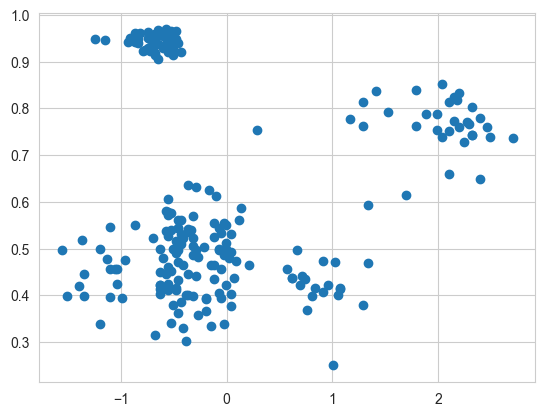

In [150]:
scaler = StandardScaler()
x_continuous = scaler.fit_transform(
    np.concatenate((g.degrees.reshape(-1, 1),
                    g.x),axis=1)
)

feat_mat  = np.hstack((x_continuous,
                          pd.get_dummies(g.cluster_labels).to_numpy(dtype=np.float16)))

weights = np.array([0, 1.5, 1.5, 2 ,2, 2, 2])

beta = np.random.uniform(size=feat_mat.shape[1]) * weights
# What distribution to take
print(beta)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Calculate the linear combination of features and beta vector
score = sigmoid(np.dot(feat_mat, beta))


plt.scatter(feat_mat[:,0],score)
plt.show()



In [38]:
def setB(m,b,d):
    """
    :param m: number of feature dimensions
    :param b: upper bound for cross community probs
    :param d: diag entries (within connection probs) 
    :return: 
    """
    B = np.random.uniform(0, b, size=(m, m))
    B = np.tril(B) + np.tril(B, -1).T
    np.fill_diagonal(B, d)
    
    return B
    
m_features = 3
k_clusters = 4
data = np.random.multivariate_normal(np.repeat(0,m_features), setB(m_features, 1,.5), k_clusters)
coordinates = [tuple(point) for point in data]
coordinates   

[(-0.1777845820335804, 0.026113457889819097, -0.1193966992915),
 (0.7796137979202312, 0.3036340175267877, 0.6041614914330018),
 (0.9324772317932271, 0.37529123430288663, 0.37466557689623825),
 (-0.29590542734794195, -0.3103551258342006, -0.4328987993088303)]

In [33]:
np.repeat(0,3)

array([0, 0, 0])